In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions

import cv2 # for image processing

In [5]:
# load the model
model = VGG16()

In [6]:
# A function that uses the VGG16 model to make predictions
# It assume that the image_array actually contains only 1 image

def predict(image_array): 
    # reshape data for the model
    image_tensor = image_array.reshape((1, image_array.shape[0], image_array.shape[1], image_array.shape[2]))
    # prepare the image for the VGG model
    image_tensor = preprocess_input(image_tensor)
    # predict the probability across all output classes
    yhat = model.predict(image_tensor)
    # convert the probabilities to class labels
    label = decode_predictions(yhat)
    # retrieve the most likely result, i.e. highest probability
    label = label[0][0]
    # return the class name and its probability
    return label[1], label[2]*100


# Modified prediction function to allow me to see probabilities of all 1000 classes
def predict_all_classes(image_array):
    # reshape data for the model
    image_tensor = image_array.reshape((1, image_array.shape[0], image_array.shape[1], image_array.shape[2]))
    # prepare the image for the VGG model
    image_tensor = preprocess_input(image_tensor)
    # predict the probability across all output classes
    yhat = model.predict(image_tensor)
    # convert the probabilities to class labels
    label = decode_predictions(yhat, top=1000)
    # retrieve the most likely result, i.e. highest probability

    # return the class name and its probability
    return label

In [7]:
# load an image from file
image = load_img('mug.jpg', target_size=(224, 224))
# convert the image pixels to a numpy array
image_array = img_to_array(image)

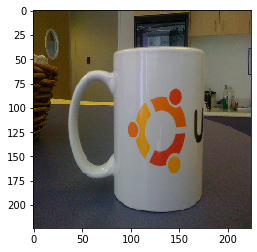

In [8]:
# display the image
plt.imshow(np.clip(image_array, 0, 255).astype("uint8"))

In [9]:
# print the classification for this image
print('%s (%.2f%%)' % predict(image_array))

coffee_mug (75.27%)


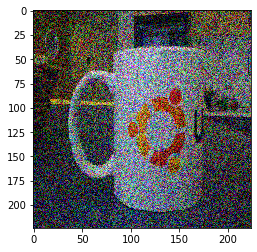

In [10]:
# Now you might do things to the image_array, e.g. here I add noise
noise = np.random.randint(0, 200, (image_array.shape[0], image_array.shape[1], image_array.shape[2]))
noisy_image_array = np.clip(image_array + noise, 0, 255)
# display the image
plt.imshow(noisy_image_array.astype("uint8"))

In [11]:
# print the classification for this image
print('%s (%.2f%%)' % predict(noisy_image_array))

maze (8.03%)


<h1>Fooling Neural Networks</h1>
<p>Through out this notebook I explore how changing images in various ways will relate to the prediction of the neural network. I use various images across my experiments. I also look at some recently publsihed research on methods of fooling neural networks.</p>

In [12]:
img_mug_file = "mug.jpg"
img_white_file = "white_mug_white_background.jpg"
img_wood_background_file = "white_mug_wood_background.jpg"
img_black_graphic_file = "black_graphic_mug_no_handle.jpg"
img_disney_file = "Disney_mug.jpg"

# Load in the pictures
img_mug = load_img(img_mug_file, target_size=(224,224))
img_white = load_img(img_white_file, target_size=(224, 224))
img_wood_bg = load_img(img_wood_background_file, target_size=(224, 224))
img_black_graphic = load_img(img_black_graphic_file, target_size=(224, 224))
img_disney = load_img(img_disney_file, target_size=(224, 224))

# Convert pictures to arrays
img_mug_array = img_to_array(img_mug)
img_white_array = img_to_array(img_white)
img_wood_bg_array = img_to_array(img_wood_bg)
img_black_graphic_array = img_to_array(img_black_graphic)
img_disney_array = img_to_array(img_disney)

img_arrays = [img_mug_array, img_wood_bg_array, img_black_graphic_array, img_disney_array]

# Function to show images
def show_images(image_arrays):
    w=10
    h=10
    fig=plt.figure(figsize=(15, 8))
    columns = 4
    rows = 1
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(np.clip(image_arrays[i - 1], 0, 255).astype("uint8"))
    plt.show()

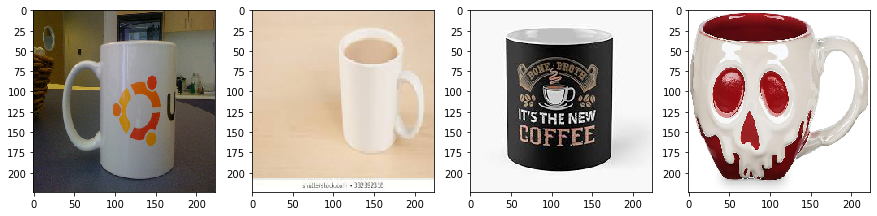

In [13]:
show_images(img_arrays)

In [14]:
images = list(map(lambda array : np.copy(array), img_arrays))

for image in images: 
    print('%s (%.2f%%)' % predict(image))

coffee_mug (75.27%)
coffee_mug (49.99%)
coffee_mug (91.95%)
cup (41.68%)


<p>While the network is very confident for the first and third image, it is less sure about the second image, maybe due to the bacground. It classified the last image as a cup, it is probably trained on many more "normal" images of mugs.</p>

<h1>Attacking the lower layers of the network</h1>

<h2>Blurring Images</h2>

<p>Lower layers of convolutional neural network focus on detecting primitive shapes. In my first attempt to fool the network, I try to alter images of coffee mugs, focusing on removeing/altering these lower level features in the images.</p>

<p>Using cv2 [5], I apply blurring to each of my images in the hope that low level features such as lines become distorted enough to no longer be recognised as such by the network.</p>

<p>OpenCV documentation [5] state that image blurring/smoothing, while reducing noise in the image, it reduced high frequency content, for example edges, which is exactly what we want to distort in order to attack the lower levels of a convolutinal network.</p>

<h3>Averaging</h3>
<p>Averaging is an image blurring technique which takes an average of a small area of an image and replaces the central element of that small area with the average.</p>

<p>I have tweaked the values of the function to achieve the most blurring in the image, while still leaving it recognisable to humans.</p>

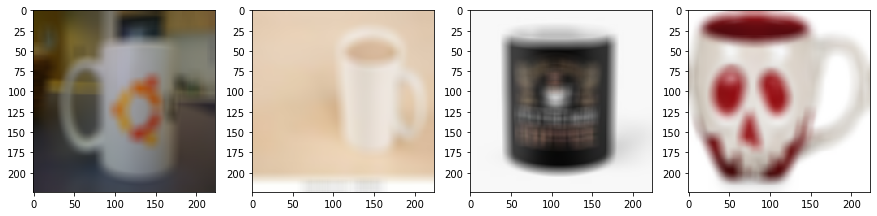

In [15]:
# Blur the images
blurred_images = list(map(lambda array : cv2.blur(array, (15,15)), img_arrays))

show_images(blurred_images)

In [16]:
# Predict each image
for blurred_image in blurred_images:
    print('%s (%.2f%%)' % predict(blurred_image))

pill_bottle (14.62%)
face_powder (13.28%)
oil_filter (49.64%)
cup (32.29%)


<h3>Results</h3>
<p>The network mis-classified 3 out of 4 mugs. This distorts the image enough to no longer be recognised as a coffee mug. (We can consider the last classification of "cup" to be correct)</p>

<h3>Gaussian Filtering</h3>
<p>Gaussian Filtering achieves the same effect of reducing detail as averaging, but a Gaussian function is used. We expect the network to misclassify these images similar to before.</p>

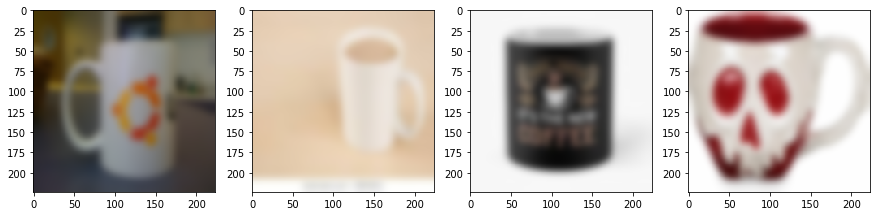

In [17]:
g_blurred_images = list(map(lambda img_array : cv2.GaussianBlur(img_array,(29,29),0), img_arrays))

show_images(g_blurred_images)

In [18]:
for blurred_image in g_blurred_images:
    print('%s (%.2f%%)' % predict(blurred_image))

pill_bottle (12.36%)
face_powder (13.53%)
oil_filter (42.99%)
nipple (26.18%)


<h3>Results</h3>
<p>Even better results this blurring technique. Every image we have has been incorrectly classified.
We can probably attribute this to the fact that blurring will make the lowest level features such as lines less distinct
and in turn harder to recognise.</p>

<h3>Bilateral Filtering</h3>
<p>In contrast to these blurring methods, Bilateral Filtering is an image-smoothing technique which preserves edges
 in our images. Because these lower level features such as edges in the images are preserved,
    we might expect an image with bilateral filtering to still be correctly classified.<p>

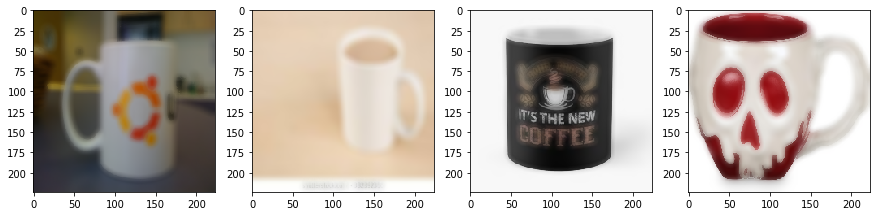

In [19]:
bf_blurred_images = list(map(lambda img_array : cv2.bilateralFilter(img_array,12,350,350), img_arrays))

show_images(bf_blurred_images)

In [20]:
for image_array in bf_blurred_images:
    print('%s (%.2f%%)' % predict(blurred_image))    

cup (14.28%)
pick (68.57%)
pick (99.16%)
pick (99.98%)


<h3>Results</h3>
<p>For some reason the network is almost certain that some of these images are picks. Maybe by using this blurring technique, we have distorted the image but the shape that is left detectible by the classifier corresponds to that of a pick.</p>

<h2>Warping the Image</h2>
<p>Using GIMP image editor, I will warp the image with the hope that the network will no longer be able ot recognise the coffee mug due to the lower level shapes being transformed.</p>

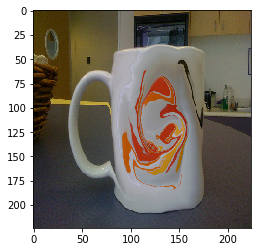

In [21]:
warped_mug = img_to_array(load_img("warped_mug_1.jpg", target_size=(224,224)))
plt.imshow(np.clip(warped_mug, 0, 255).astype("uint8"))

In [22]:
print('%s (%.2f%%)' % predict(warped_mug))

coffee_mug (87.34%)


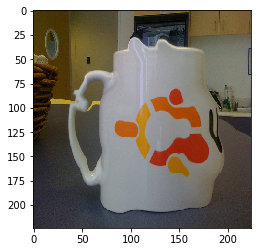

In [23]:
warped_mug = img_to_array(load_img("warped_mug_2.jpg", target_size=(224,224)))
plt.imshow(np.clip(warped_mug, 0, 255).astype("uint8"))

In [24]:
print('%s (%.2f%%)' % predict(warped_mug))

teapot (69.21%)


<h3>Result</h3>
<p>The network still strongly recognises the first image as a coffee mug. This is probably due to the basic shape still being distictly present in the image. In the second image I try to distort that basic shape and it now predicts the wrong class. The evidence so far suggests that the basic shape of an object is a key factor in determining the prediction.</p>

<h2>Changing Brightness</h2>
<p>In this experiment, we will see how varying the brightness of the image changes the predictions of the network.</p>

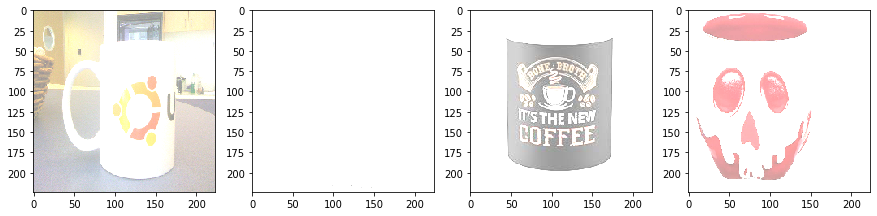

In [25]:
bright_images = list(map(lambda img_array : img_array + 150, img_arrays))
show_images(bright_images)

In [26]:
for img_array in bright_images:
    print('%s (%.2f%%)' % predict(img_array))

coffee_mug (71.18%)
cup (63.53%)
coffee_mug (88.33%)
cup (59.61%)


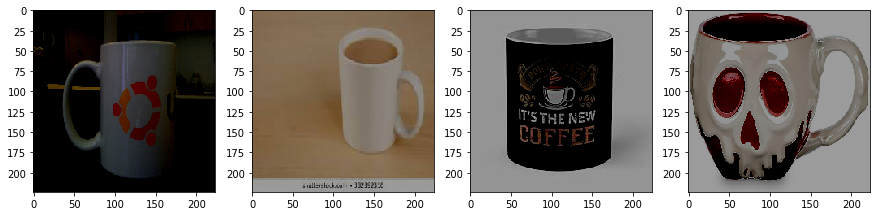

In [27]:
dark_images = list(map(lambda img_array : img_array - 100, img_arrays))
show_images(dark_images)

In [28]:
for img_array in dark_images:
    print('%s (%.2f%%)' % predict(img_array))

coffee_mug (87.08%)
coffee_mug (25.23%)
coffee_mug (88.38%)
cup (38.63%)


<h3>Result</h3>
<p>Increasing and decreases brightness in the image doesn't seem to much of a difference, the confidence of the network only decreases slightly. My guess here is that the classifier still recognises the distinct pattern of the object in the picture and classifies it correctly from that. In fact, the predictions seem to be more confident. This might be because when we raise/lower brightness, the background becomes less prominent, allowing the network to focus on the object.</p>

<h2>Experimenting with color</h2>
<p>In the following experiments, we will try to modify color of images. Maybe by showing the network an image of a coffee mug with strange colours, it will mis-classify it. This does depend on how much the network uses colour as a contributing factor to the prediction.</p>

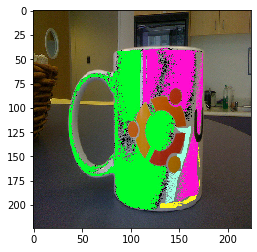

In [29]:
coloured_mug = img_to_array(load_img("colour_mug.jpg", target_size=(224,224)))

plt.imshow(np.clip(coloured_mug, 0, 255).astype("uint8"))

In [30]:
print('%s (%.2f%%)' % predict(coloured_mug))

coffee_mug (19.33%)


<h3>Result</h3>
<p>While the network correctly classifies the image, it is much less confident in its prediction. This could be due to the network being trained on more "regular" images of mugs that doen't feature such colours.</p>

<h1>Attacking the upper layers of the network</h1>

<p>The upper layers of the network focus on finding complex shapes. What complex shapes are in a coffee mug? 
A semi circle attached to a roughly cylindrical shape seems distinctive of mugs. This is the shape we will try to distort in the hope that the network will mis-classify the image because it is missing these distinctive shapes.</p>

<h2>Removing a Distinctive Feature</h2>
<p>Using GIMP, we will remove the handle (as best as we can) in the hope of fooling the network. The next cell contains the modified images I have created.</p> 

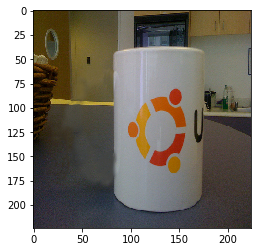

In [31]:
img_no_handle = img_to_array(load_img("mug_no_handle.jpg", target_size=(224,224)))

plt.imshow(np.clip(img_no_handle, 0, 255).astype("uint8"))

In [32]:
print('%s (%.2f%%)' % predict(img_no_handle))

paper_towel (22.50%)


<h3>Result</h3>
<p>We have successfully removed the handle and the network now classifies it as a papaer towel. We have taken away a distinctive shape and the shape that remains seems more like a paper towel than a coffee mug.</p>

<h2>Including distinctive features of another class</h2>
<p>So far we have tried making modifications to the image so that it does not predict coffee mug, but now we will try a different approach to fooling the network. In an effort to make the network predict a specific different class, we will try to include distinctive features of another class in our images. The aim here is to include a feature of an alternate class that would only feature in that class. It is hoped that the network will recognise this feature in its upper layers of neurons, and becuase this is a rare feature, it will push the network towards predicting the alternate class.<p>

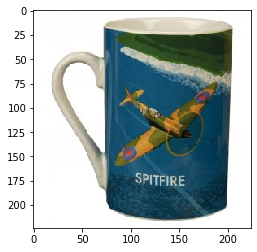

In [33]:
aeroplane_mug = img_to_array(load_img("aeroplane_mug.jpg", target_size=(224,224)))

plt.imshow(np.clip(aeroplane_mug, 0, 255).astype("uint8"))

In [34]:
print('%s (%.2f%%)' % predict(aeroplane_mug))

coffee_mug (76.25%)


<h3>Result</h3>
<p>Here we try to make the network predict "Aeroplane" or related item because of the graphic picture on the mug. In this case, the image was not enough for the network to not classify the image as a coffee mug.</p>

<p>Below I have taken a picture of a lesser panda and taped it to a mug. The photo still has some features distinctive of a coffee mug, but we hope that the features of the lesser panda are enough to make the network classify the image as such.</p>

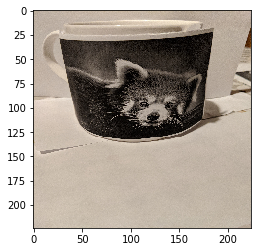

In [35]:
x = img_to_array(load_img("mug_panda_real_2.jpg", target_size=(224,224)).rotate(270))

plt.imshow(np.clip(x, 0, 255).astype("uint8"))

In [36]:
print('%s (%.2f%%)' % predict(x))

weasel (13.59%)


<h3>Results</h3>
<p>We have successfully fooled the classifier. In this case it predicted a weasel instead of a lesser panda, but this illustrates the point of including features of other classes that are rare features among the entire collection of possible classes.</p>

<h2>Backgrounds/Envrionments</h2>
<p>Here we will investigate how the enivornment that the object is in contributes to the prediction. Using GIMP I have pasted the image of a coffee mug into a grassy background. The hope is that the network will see the background and be more compelled to predict the object as some garder tool or an outdoors related item.</p>

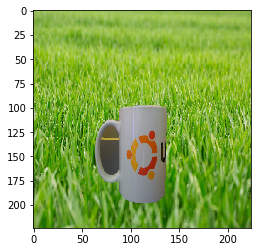

In [37]:
mug_in_grass = img_to_array(load_img("mug_in_grass.jpg", target_size=(224,224)))

plt.imshow(np.clip(mug_in_grass, 0, 255).astype("uint8"))

In [38]:
print('%s (%.2f%%)' % predict(mug_in_grass))

cup (42.36%)


<h3>Result</h3>
<p>The prediction has changed from mug to about 40% sure its a cup. The background has influenced things but not too significantly. The network still seems to weight most of the classification on the object itself, making some but not too much use of other factors such as environment.</p>

<h2>Strange Angles</h2>
<p>Here we will look at whether the network will recognise a cofffee mug even if the picture is from a slightly unusual angle. Below I have taken an overhead picture of a mug.</p>

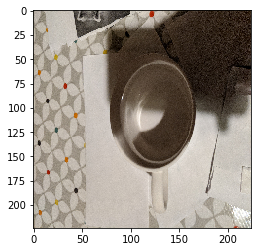

In [43]:
overhead_mug = img_to_array(load_img("over_mug.jpg", target_size=(224, 224)))

plt.imshow(np.clip(overhead_mug, 0, 255).astype("uint8"))

In [44]:
print('%s (%.2f%%)' % predict(overhead_mug))

loudspeaker (37.58%)


<h3>Result</h3>
<p>The network thinks this mug is a loudspeaker! The shadows are a bit unusual, but this shows that the network can struggle with objects at different angles. This is probably because the network wasn't trained on enough of these different angles and that by changing angle, we have removed some distinct features that make it seem like a coffee mug (e.g. the handle shape).</p>

<h2>Basic Shape</h2>
<p>Below I have drawn the most basic shape of a coffee mug to see how the network responds.</p>

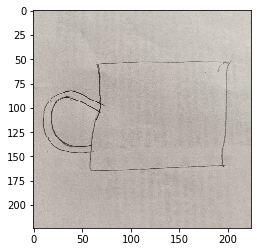

In [52]:
drawing = img_to_array(load_img("drawing_3.jpg", target_size=(224,224)).rotate(270))
plt.imshow(np.clip(drawing, 0, 255).astype("uint8"))

In [53]:
print('%s (%.2f%%)' % predict(overhead_mug))

loudspeaker (93.05%)


<h3>Result</h3>
<p>The network is extremely confident that the drawing is a loudspeaker. Maybe the network relies on a 3d image to be able to detemrine what the object is, since it was probably trained on mostly 3d images, and my 2d drawing of a coffee mug mostly resembles a 3d version of a speaker rather than a coffee mug.</p>

<h2>One Pixel Attack</h2>
<p>In a paper by Jiawei Su et al, published in 2019 [7], they outline a method for fooling deep neural networks. Essentially by altering one pixel of an entire image, they are able to make the network predict the wrong class with high confidence in the networks choice. I try to apply this idea here. The authors use differential evolution [8, 9], a genetic algorithm, to find the x and y co-ordinate of the pixel they want to change, and also the RGB value to change it to. Using scipy, I try to mimic the approach by trying to maximimse the probability of the coffee mug being a paper_towel.</p>

In [39]:
im = img_to_array(load_img("mug.jpg", target_size=(224, 224)))


def optimize(inp):
    x, y, r, g, b = int(inp[0]), int(inp[1]), int(inp[2]), int(inp[3]), int(inp[4])
    copy = np.copy(im)
    copy[x][y][0] = r
    copy[x][y][1] = g
    copy[x][y][2] = b
    predictions = predict_all_classes(copy)[0]
    for pred in predictions:
        if pred[1] == "paper_towel":
            print(pred[2])
            return 1 - pred[2]

from scipy.optimize import differential_evolution
differential_evolution(lambda x : optimize(x), [(0, 224), (0,224), (0, 255), (0,255), (0,255)], maxiter=5000)

0.0002370524
0.00024474732
0.00024837724
0.00026821753
0.0002382214
0.00026554067
0.0002674044
0.00023707181
0.0002500183
0.00021039705
0.00023846772
0.00024313762
0.00025887776
0.00023917905
0.00022713149
0.00023555783
0.00024178292
0.00023421847
0.00023855647
0.00025115756
0.00022606274
0.00024166005
0.00023845262
0.00024225318
0.00019145406
0.00024208911
0.00024773314
0.0002393488
0.0002396362
0.00023500163
0.0002278926
0.00024119962
0.00023626459
0.00023136017
0.0002170476
0.00023671411
0.00023691708
0.0002458031
0.00022566125
0.00020495185
0.00024207638
0.00023186427
0.00023312146
0.00023931032
0.00022401164
0.0002575206
0.00022239413
0.00024547294
0.00024340297
0.00023838576
0.00024558225
0.00023532323
0.00023756882
0.00024254894
0.0002480181
0.0002297166
0.00025304168
0.00019727992
0.0002136436
0.00023972116
0.0002727752
0.00024150571
0.000233667
0.00023977419
0.00024532125
0.000248207
0.00023551077
0.00023797924
0.00020515443
0.00022174405
0.00023400212
0.00021412081
0.00023917

     fun: 0.9997169577691238
 message: 'Optimization terminated successfully.'
    nfev: 156
     nit: 1
 success: True
       x: array([204.92416085, 177.56875146, 228.16222066, 241.67499933,
        64.35715139])

<h3>Results</h3>
<p>Unfortunately I was unable to get the differential agorithm to find a pertubation that would fool the classifier. By printing out the probability of the mug being a paper towel at each iteration, you can see that it is increasing, indicating that the differential algorithm is doing something right and that even changing one pixel in the image can influence the networks prediction. The authors of the paper do achieve significantly better results, but do not discuss why the attack works. Maybe it is due to disruption to a specific feature in the image that the network relies on to make the classification.</p>

<h2>Adversarial Patch</h2>
<p>In a 2018 paper [10], researchers showed that by placing a sticker in the frame of the image, you could ge the network to falsly classify the image with a high probability. Below, I apply the technique. Using GIMP, I have overlayed a patch onto the image.</p>

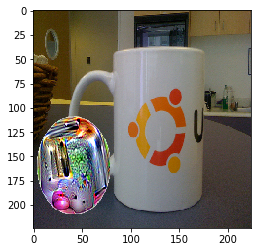

In [40]:
mug_with_sticker = img_to_array(load_img("mug_with_sticker_2.jpg", target_size=(224,224)))

plt.imshow(np.clip(mug_with_sticker, 0, 255).astype("uint8"))

In [41]:
print('%s (%.2f%%)' % predict(mug_with_sticker))

toaster (99.97%)


<h3>Results</h3>
<p>The network classifies this image as a toaster with an very high probability. The authors of the paper reason that the attack works so well because networks are trained to detect the most prominent item in the image. When we include the patch, its distinctive features make it the most important item, and so the network focusses on classifying what the patch is, ignoring the mug.</p>

<h1>Conclusions</h1>
<p>In this notebook we have explored how we can fool deep neural networks with some basic image manipulation techniques including bluring and warping and modifying colour. We then explored some recent research on how to fool neural networks. In summary it seems that there are many ways of influencing the prediction made by the network such as removing features distinctive of the real class, adding noise to the image, or distracting the network from the main object with another point of interest.</p>

<h1>References</h1>
<ol>
    <li>Black coffee mug is from an <a href="https://www.amazon.com/Bone-Broth-Nutritious-Soups-Stock/dp/B07W7L3Z8Q">Amazon listing</a></li>
    <li>White coffee mug is from <a href="https://www.shutterstock.com/search/tea+mugs">Shutter Stock</a></li>
    <li>Disney mug is from an <a href="https://www.amazon.com/Disney-Poisoned-Apple-Sculptured-Dwarfs/dp/B06XGN53TS">Amazon listing</a></li>
    <li>Code for showing images from <a href="https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly">this stackoverflow post</a></li>
    <li>Code for blurring and warping images are from OpenCV documentation, <a href="https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_table_of_contents_imgproc/py_table_of_contents_imgproc.html">Image Processing in OpenCV</a></li>
    <li>Picture of grass is from <a href="https://www.pennington.com/all-products/grass-seed/resources/how-your-lawn-helps-the-environment">Pennington.com</a></li>
    <li>One Pixel Attack idea taken from Jiawei su et al, <a href="https://arxiv.org/pdf/1710.08864.pdf">One Pixel Attack for Fooling Deep Neural Networks</a>, 2019</li>
    <li>I read about differential evolution on <a href="https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/">Pablo R. Mier's blog</a></li>
    <li>Code for differential evolution is from scipy documentation, <a href="https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.optimize.differential_evolution.html">Scipy.org - scipy.optimize.differential_evolution</a></li>
    <li>Adversarial patch idea taken from Tom B. Brown et al, <a href="https://arxiv.org/pdf/1712.09665.pdf">Adversarial Patch</a>, 2018</li>
</ol>